In [1]:
import json
import os
import tempfile
import time
from matplotlib.collections import Collection
from copy import deepcopy
import networkx as nx
import torch
from torch import nn
import torch.nn.functional as F
import sys
import dgl
import numpy as np
import pandas as pd
from tqdm import tqdm as tq
import mlflow
from collections import defaultdict
sys.path.append('..')
from model.models_dgl import FixedNet2
from collections import Counter
from benchmarks.build_graph import BA4labelDataset,build_graph
from benchmarks.benchmark_dgl import Benchmark
from method.explain_methods_dgl import explain_random, explain_ig, explain_sa, explain_gnnexplainer, explain_pgmexplainer
import matplotlib.pyplot as plt
def draw_explanation(g, edge_mask):
    plt.figure(figsize=(25,25),edgecolor='g')
    fig,ax = plt.subplots(figsize=(10,10))
    g = g.to(torch.device('cpu'))
    g.edata['weight'] = torch.tensor(edge_mask)
    g_nx = dgl.to_networkx(g,edge_attrs=['weight']) 
    edges = g_nx.edges()
    weights = [g_nx[u][v][0]['weight']*0.5+0.2 for u,v in edges]
    pos = nx.spring_layout(g_nx)
    nx.draw_networkx_nodes(g_nx,pos)
    nx.draw_networkx_edges(g_nx,pos, width=weights,connectionstyle="arc3,rad=0.3")

class BA4label(Benchmark):
    NUM_TRAIN_GRAPHS = 1000
    NUM_NODES = 50
    TEST_RATIO = 0.001
    LR = 0.003
    M = 5
    print(NUM_NODES,M)
    NO_ATTACH_INIT_NODES = True

    @staticmethod
    def get_accuracy(g, correct_ids, edge_mask):
        '''
        edge_index: 2 elements tuple, u and v
        '''
        if correct_ids == []:
            if np.all(np.mean(edge_mask) == edge_mask):
                return 1
            else:
                return 0
        else:
            correct_edges = set()
            for i in range(g.num_edges()):
                u = g.edges()[0][i].item()
                v = g.edges()[1][i].item()
                if u in correct_ids and v in correct_ids: #每个双向边都计入，是否要将边缘的边改为只计入一遍？
                    correct_edges.add((u,v))
                    correct_edges.add((v,u))
                elif v in correct_ids:
                    correct_edges.add((u,v))
                else:
                    continue
            #按照单向边来计算
            correct_count = 0
            for x in np.argsort(-edge_mask)[:len(correct_edges)]:
                u = g.edges()[0][x].item()
                v = g.edges()[1][x].item()
                if (u, v) in correct_edges:
                    correct_count += 1
            #双向边只要对一条就算对 注意 此时正确边要包含每个双向边
            '''
            mask_edges = set()
            for x in np.argsort(-edge_mask)[:len(correct_edges)]:
                u = g.edges[0][x].item()
                v = g.edges[1][x].item()
                if ( (u, v) in correct_edges or (v, u) in correct_edges ) and (v, u) not in mask_edges:
                    mask_edges.add((v,u))
                    correct_count += 2
            '''
            return correct_count / len(correct_edges)

    def create_dataset(self, graphs_num, m = 6, nodes_num = 50, include_bias_class = True):
        '''
        Return data
        '''
        data = BA4labelDataset(graphs_num=graphs_num, m = m, nodes_num=nodes_num, perturb_dic = {}, no_attach_init_nodes = True, include_bias_class=include_bias_class)
        print('created one')
        return data

    def is_trained_model_valid(self, test_acc):
        return test_acc == 1

    def evaluate_explanation(self, explain_function, model, test_dataset, explain_name, iteration = 1, summarytype = 'sum'):
        accs = []
        tested_graphs = 0
        accs1 = []
        accs2 = []
        accs3 = []
        accs4 = []
        for g, label in tq(test_dataset):
            g = g.to(self.device)
            tested_graphs += 1
            edge_mask = explain_function(model, 'graph', g, g.ndata['x'], label)

            if iteration != 1:
                edge_mask_list = [deepcopy(edge_mask)]
                for _ in range(1,iteration):
                    new_edge_mask = explain_function(model, 'graph', g, g.ndata['x'], label)
                    edge_mask_list.append(new_edge_mask)
                
                for summarytype in ['sum','count13','count26','rank']:
                    edge_mask = deepcopy(edge_mask_list[0])
                    if summarytype == 'sum':
                        for i in range(1, iteration):
                            edge_mask += edge_mask_list[i]
                        sum_edge_mask = edge_mask
                    if summarytype == 'count26':#influence by threshold and not be appropriate to stable method
                        top_edges_index = list(np.argsort(-edge_mask)[:26])
                        for j in range(1, iteration):
                            edge_mask = edge_mask_list[j]
                            top_edges_index.extend(list(np.argsort(-edge_mask)[:26]))
                        edges_index_dic = Counter(top_edges_index)
                        edge_mask = np.zeros(g.num_edges())
                        for k,v in edges_index_dic.items():
                            edge_mask[k] = v 
                        count26_edge_mask = edge_mask
                    if summarytype == 'rank':
                        edges_index = np.argsort(-edge_mask)
                        edges_rank = {}
                        for i in range(len(edges_index)):
                            edges_rank[edges_index[i]] = i
                        for j in range(1, iteration):
                            edge_mask = edge_mask_list[j]
                            edges_index = np.argsort(-edge_mask)
                            for i in range(len(edges_index)):
                                edges_rank[edges_index[i]] += i
                        edge_mask = []
                        for i in range(g.num_edges()):
                            edge_mask.append(edges_rank[i])
                        edge_mask = -np.array(edge_mask)
                        rank_edge_mask = edge_mask
                    if summarytype == 'count13':#influence by threshold and not be appropriate to stable method
                        top_edges_index = list(np.argsort(-edge_mask)[:13])
                        for j in range(1, iteration):
                            edge_mask = edge_mask_list[j]
                            top_edges_index.extend(list(np.argsort(-edge_mask)[:13]))
                        edges_index_dic = Counter(top_edges_index)
                        edge_mask = np.zeros(g.num_edges())
                        for k,v in edges_index_dic.items():
                            edge_mask[k] = v 
                        count13_edge_mask = edge_mask
                if label == 0:
                    correct_ids = []
                else:
                    correct_ids = [x for x in range(len(g.nodes())-10,len(g.nodes()))]
                explain_acc = self.get_accuracy(g, correct_ids, sum_edge_mask)
                accs1.append(explain_acc)
                explain_acc = self.get_accuracy(g, correct_ids, count13_edge_mask)
                accs2.append(explain_acc)
                explain_acc = self.get_accuracy(g, correct_ids, rank_edge_mask)
                accs3.append(explain_acc)
                explain_acc = self.get_accuracy(g, correct_ids, count26_edge_mask)
                accs4.append(explain_acc)
                edge_mask = edge_mask_list[0]
                
            if label == 0:
                correct_ids = []
            else:
                correct_ids = [x for x in range(len(g.nodes())-10,len(g.nodes()))]

            explain_acc = self.get_accuracy(g, correct_ids, edge_mask)
            draw_explanation(g, edge_mask)
            g = g.to(self.device)
            accs.append(explain_acc)
        if iteration != 1:
            return accs,accs1,accs2,accs3,accs4
        return accs

    def train(self, model, optimizer, train_loader):
        #need to train
        loss_all = 0
        for g, label in train_loader:
            g = g.to(self.device)
            label = label.to(self.device)
            optimizer.zero_grad()
            output = model(g, g.ndata['x'])
            loss = F.nll_loss(output.float(), label)
            loss.backward()
            loss_all += loss.item()
            optimizer.step()
        return loss_all / len(train_loader)


    def test(self, model, loader):
        model.eval()

        correct = 0
        total = 0
        for g, label in loader:
            g = g.to(self.device)
            label = label.to(self.device)
            output = model(g, g.ndata['x'])
            pred = output.max(dim=1)[1]
            correct += pred.eq(label).sum().item()
            total += len(label)
        return correct / total

    def train_and_test(self, model, train_loader, test_loader):
        optimizer = torch.optim.Adam(model.parameters(), lr=self.LR, weight_decay=self.WEIGHT_DECAY)
        mlflow.log_param('weight_decay', self.WEIGHT_DECAY)
        mlflow.log_param('lr', self.LR)
        mlflow.log_param('epochs', self.EPOCHS)
        pbar = tq(range(self.EPOCHS))
        for epoch in pbar:
            train_loss = self.train(model, optimizer, train_loader)
            train_acc = self.test(model, train_loader)
            test_acc = self.test(model, test_loader)
            pbar.set_postfix(train_loss=train_loss, train_acc=train_acc, test_acc=test_acc)
        return train_acc, test_acc


    def run(self):
        print(f"Using device {self.device}")
        benchmark_name = self.__class__.__name__
        all_explanations = defaultdict(list)
        all_runtimes = defaultdict(list)
        for experiment_i in range(1):
            train_dataset = self.create_dataset(self.NUM_TRAIN_GRAPHS, self.M, self.NUM_NODES, include_bias_class = True)
            test_dataset = self.create_dataset(int(self.NUM_TRAIN_GRAPHS*self.TEST_RATIO), self.M, self.NUM_NODES, include_bias_class = False)

            train_dataloader = dgl.dataloading.GraphDataLoader(train_dataset, batch_size = 32, shuffle = True)
            test_dataloader = dgl.dataloading.GraphDataLoader(test_dataset, batch_size = 1, shuffle = True)
            model = Net2(1, 4, 2, False, 'GraphConvWL').to(self.device)
            model.to(self.device)
            train_acc, test_acc = self.train_and_test(model, train_dataloader, test_dataloader)
            if not self.is_trained_model_valid(test_acc):
                print('Model accuracy was not valid, ignoring this experiment')
                continue
            model.eval()
            metrics = {
                'train_acc': train_acc,
                'test_acc': test_acc,
            }
            mlflow.log_metrics(metrics, step=experiment_i)

            for explain_name in self.METHODS:
                explain_function = eval('explain_' + explain_name)
                duration_samples = []

                def time_wrapper(*args, **kwargs):
                    start_time = time.time()
                    result = explain_function(*args, **kwargs)
                    end_time = time.time()
                    duration_seconds = end_time - start_time
                    duration_samples.append(duration_seconds)
                    return result

                time_wrapper.explain_function = explain_function
                accs = self.evaluate_explanation(time_wrapper, model, test_dataset, explain_name)
                print(f'Benchmark:{benchmark_name} Run #{experiment_i + 1}, Explain Method: {explain_name}, Accuracy: {np.mean(accs)}')

                all_explanations[explain_name].append(list(accs))
                all_runtimes[explain_name].extend(duration_samples)
                metrics = {
                    f'explain_{explain_name}_acc': np.mean(accs),
                    f'time_{explain_name}_s_avg': np.mean(duration_samples),
                }
                with tempfile.TemporaryDirectory() as tmpdir:
                    file_path = os.path.join(tmpdir, 'accuracies.json')
                    json.dump(all_explanations, open(file_path, 'w'), indent=2)
                    mlflow.log_artifact(file_path)
                mlflow.log_metrics(metrics, step=experiment_i)

                '''iteration_num = 10
                summary_type = 'sum'

                time_wrapper.explain_function = explain_function
                accs, accs1, accs2, accs3, accs4 = self.evaluate_explanation(time_wrapper, model, test_dataset, explain_name, iteration = iteration_num, summarytype = summary_type)
                print(f'Benchmark:{benchmark_name} Run #{experiment_i + 1}, Explain Method: {explain_name}+{iteration_num}, Accuracy: {np.mean(accs)}')
                print(f'Benchmark:{benchmark_name} Run #{experiment_i + 1}, Explain Method: {explain_name}+{iteration_num}+sum, Accuracy: {np.mean(accs1)}')
                print(f'Benchmark:{benchmark_name} Run #{experiment_i + 1}, Explain Method: {explain_name}+{iteration_num}+count13, Accuracy: {np.mean(accs2)}')
                print(f'Benchmark:{benchmark_name} Run #{experiment_i + 1}, Explain Method: {explain_name}+{iteration_num}+rank, Accuracy: {np.mean(accs3)}')
                print(f'Benchmark:{benchmark_name} Run #{experiment_i + 1}, Explain Method: {explain_name}+{iteration_num}+count26, Accuracy: {np.mean(accs4)}')
                
                all_explanations[explain_name].append(list(accs))
                all_explanations[explain_name+str(iteration_num)+'sum'].append(list(accs1))
                all_explanations[explain_name+str(iteration_num)+'count13'].append(list(accs2))
                all_explanations[explain_name+str(iteration_num)+'rank'].append(list(accs3))
                all_explanations[explain_name+str(iteration_num)+'count26'].append(list(accs4))
                
                all_runtimes[explain_name].extend(duration_samples)
                all_runtimes[explain_name+str(iteration_num)+'sum'].extend(duration_samples)
                all_runtimes[explain_name+str(iteration_num)+'count13'].extend(duration_samples)
                all_runtimes[explain_name+str(iteration_num)+'rank'].extend(duration_samples)
                all_runtimes[explain_name+str(iteration_num)+'count26'].extend(duration_samples)

                metrics = {
                    f'explain_{explain_name}_acc': np.mean(accs),
                    f'time_{explain_name}_{iteration_num}_avg': np.mean(duration_samples),

                    f'explain_{explain_name}_{iteration_num}_sum_acc': np.mean(accs1),
                    f'time_{explain_name}_{iteration_num}_sum_avg': np.mean(duration_samples),
                    
                    f'explain_{explain_name}_{iteration_num}_count13_acc': np.mean(accs2),
                    f'time_{explain_name}_{iteration_num}_count13_avg': np.mean(duration_samples),
                    
                    f'explain_{explain_name}_{iteration_num}_rank_acc': np.mean(accs3),
                    f'time_{explain_name}_{iteration_num}_rank_avg': np.mean(duration_samples),

                    f'explain_{explain_name}_{iteration_num}_count26_acc': np.mean(accs4),
                    f'time_{explain_name}_{iteration_num}_count26_avg': np.mean(duration_samples),
                }
                with tempfile.TemporaryDirectory() as tmpdir:
                    file_path = os.path.join(tmpdir, 'accuracies.json')
                    json.dump(all_explanations, open(file_path, 'w'), indent=2)
                    mlflow.log_artifact(file_path)
                mlflow.log_metrics(metrics, step=experiment_i)'''


            print(f'Benchmark:{benchmark_name} Run #{experiment_i + 1} finished. Average Explanation Accuracies for each method:')
            accuracies_summary = {}
            for name, run_accs in all_explanations.items():
                run_accs = [np.mean(single_run_acc) for single_run_acc in run_accs]
                accuracies_summary[name] = {'avg': np.mean(run_accs), 'std': np.std(run_accs), 'count': len(run_accs)}
                print(f'{name} : avg:{np.mean(run_accs)} std:{np.std(run_accs)}')
            runtime_summary = {}
            for name, runtimes in all_runtimes.items():
                runtime_summary[name] = {'avg': np.mean(runtimes), 'std': np.std(runtimes)}
            with tempfile.TemporaryDirectory() as tmpdir:
                file_path = os.path.join(tmpdir, 'summary.json')
                summary = {'accuracies': accuracies_summary, 'runtime': runtime_summary}
                json.dump(summary, open(file_path, 'w'), indent=2)
                mlflow.log_artifact(file_path)

Using backend: pytorch


50 5


In [13]:
data = BA4labelDataset(graphs_num=100, m = 5, nodes_num=50, perturb_dic = {}, no_attach_init_nodes = True, include_bias_class=False)
test_dataloader = dgl.dataloading.GraphDataLoader(data, batch_size = 1, shuffle = True)

In [14]:
device = torch.device('cuda:0')
dif_list = []
div_list = []
acc_list = []
for i in tq(range(30)):
    model = torch.load('/home/ubuntu/Maolin/eva_gnn/dgl-gnn-exp/model'+str(i)+'.pkl')
    model.to(device)
    for g, label in test_dataloader:
        g = g.to(device)
        edge_mask = explain_ig(model, 'graph', g, g.ndata['x'], label)
        model_result = model(g, g.ndata['x']).detach().cpu().numpy()[0]
        dif = np.max(model_result)-np.sort(model_result)[-2]
        div = np.sort(model_result)[-2]/np.max(model_result)
        acc = BA4label.get_accuracy(g, list(range(g.num_nodes()-10, g.num_nodes())), edge_mask)
        dif_list.append(dif)
        div_list.append(div)
        acc_list.append(acc)


 10%|█         | 3/30 [06:10<55:30, 123.35s/it]<ipython-input-14-51701b95f2da>:13: RuntimeWarning: divide by zero encountered in float_scalars
  div = np.sort(model_result)[-2]/np.max(model_result)
100%|██████████| 30/30 [1:01:21<00:00, 122.73s/it]


In [23]:
div_list = np.array(div_list)
div_list[div_list==3.4*(10**38)]=-np.Inf

In [33]:
ignore_index = []
for i in range(len(div_list)):
    if div_list[i] == max(div_list):
        ignore_index.append(i)

In [40]:
ingore_div_list = np.delete(div_list, ignore_index)
ingore_acc_list = np.delete(acc_list, ignore_index)


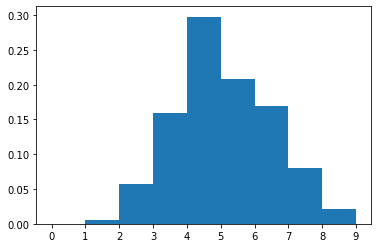

In [39]:
plt.hist(np.log10(ingore_div_list), bins = [i for i in range(10)],density = True)
plt.xticks([i for i in range(10)])
plt.show()

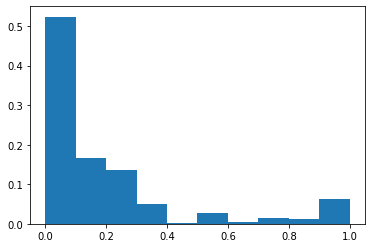

In [57]:
weight = np.ones_like(ingore_acc_list)/len(ingore_acc_list)
plt.hist(ingore_acc_list, weights = weight)
plt.show()

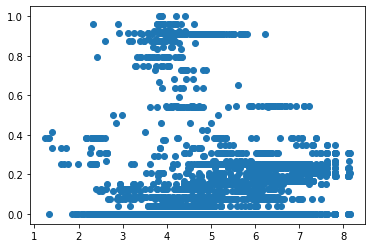

In [41]:
plt.scatter(np.log10(ingore_div_list), ingore_acc_list)

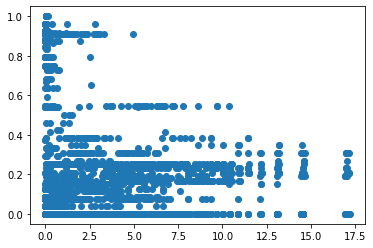

In [48]:
plt.scatter((np.log10(ingore_div_list)-4)**2, ingore_acc_list)

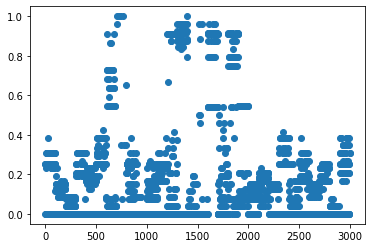

In [43]:
plt.scatter(list(range(len(acc_list))),acc_list)

In [44]:
from scipy import stats

In [46]:
stats.levene(np.log10(ingore_div_list), ingore_acc_list)

LeveneResult(statistic=3636.126999637243, pvalue=0.0)

In [45]:
stats.pearsonr(np.log10(ingore_div_list), ingore_acc_list)

(-0.0901460608994123, 7.855929513121784e-07)

In [49]:
stats.spearmanr(np.log10(ingore_div_list), ingore_acc_list)

SpearmanrResult(correlation=0.06639462323763308, pvalue=0.00027881841616097847)

In [50]:
stats.kendalltau(np.log10(ingore_div_list), ingore_acc_list)

KendalltauResult(correlation=0.05489999887066058, pvalue=2.320544780323743e-05)

# 二次

In [52]:
stats.levene((np.log10(ingore_div_list)-4)**2, ingore_acc_list)

LeveneResult(statistic=1548.5837259515913, pvalue=2.0408340331506095e-301)

In [53]:
stats.spearmanr((np.log10(ingore_div_list)-4)**2, ingore_acc_list)

SpearmanrResult(correlation=0.04185135792879946, pvalue=0.0220630165897766)